<a href="https://colab.research.google.com/github/zharfanw/fd_zharram/blob/main/FDProject_MinimizePower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fullduplex Project : Transmit Power Minimization for Double-RIS-Enabled ISAC System**

This notebook referenced by this paper [Transmit Power Minimization for Double-RIS-Enabled ISAC System](https://ieeexplore.ieee.org/document/10681845)


In [58]:
!pip install cvxpy
# !pip install jupyter_contrib_nbextensions
# !jupyter contrib nbextension install --user
# !jupyter nbextension enable varInspector/main

## Symbol List


In [59]:
import numpy as np
import cvxpy as cp

## Parameter Building *Up*

Position ANTENNA

| Channel               | Notasi Channel | Posisi Awal → Akhir           | Jarak (`dist`) yang digunakan |
| --------------------- | -------------- | ----------------------------- | ----------------------------- |
| BS → RIS1             | `H1`           | BS (0, 0) → RIS1 (2, 2)       | ≈ 2.83 m                      |
| BS → RIS2             | `H2`           | BS (0, 0) → RIS2 (48, 2)      | ≈ 48.04 m                     |
| RIS1 → RIS2           | `G`            | RIS1 (2, 2) → RIS2 (48, 2)    | ≈ 46.00 m                     |
| RIS1 → sensing target | —              | RIS1 (2, 2) → Target (10, -2) | ≈ 8.94 m                      |
| BS → sensing target   | —              | BS (0, 0) → Target (10, -2)   | ≈ 10.20 m                     |
| RIS2 → User (k)       | —              | RIS2 (48, 2) → User (50, 0)   | ≈ 2.83 m                      |
| BS → User (k)         | —              | BS (0, 0) → User (50, 0)      | 50.00 m                       |


Rincian Parameter Channel

| Channel                 | Rician Factor (ε)          | TX   | RX   | Jumlah Antena       | Path Loss Exponent (τ) | Referensi Path Loss (PL₀ @ d₀ = 1m) |
| ----------------------- | -------------------------- | ---- | ---- | ------------------- | ---------------------- | ----------------------------------- |
| BS → RIS1 (`H1`)        | **3**                      | BS   | RIS1 | BS: M = 8, RIS1: N₁ | **2.2**                | **−30 dBm**                         |
| BS → User (`h_{b,k}`)   | **1**                      | BS   | User | BS: M = 8, User: 1  | **2.5**                | **−30 dBm**                         |
| RIS1 → User (`h_{1,k}`) | **3**                      | RIS1 | User | RIS1: N₁, User: 1   | **2.5**                | **−30 dBm**                         |
| RIS2 → User (`h_{2,k}`) | **3**                      | RIS2 | User | RIS2: N₂, User: 1   | **2.2**                | **−30 dBm**                         |
| BS → RIS2 (`H2`)        | *Kemungkinan 3 (implisit)* | BS   | RIS2 | BS: M = 8, RIS2: N₂ | **2.2**                | **−30 dBm**                         |
| RIS1 → RIS2 (`G`)       | *Kemungkinan 3 (implisit)* | RIS1 | RIS2 | RIS1: N₁, RIS2: N₂  | **2.2**                | **−30 dBm**                         |



Channel                   Distance (m)    φ (rad)      φ (°)
-----------------------------------------------------------------
BS → RIS1 (H1)                  2.83      +0.7854      +45.00
BS → RIS2 (H2)                 48.04      +0.0416      +2.39
BS → Target                    10.20      -0.1974      -11.31
BS → User                      50.00      +0.0000      +0.00
RIS1 → RIS2 (G)                46.00      +0.0000      +0.00
RIS1 → Target                   8.94      -0.4636      -26.57
RIS1 → User                    48.04      -0.0416      -2.39
RIS2 → User                     2.83      -0.7854      -45.00
RIS2 → Target                  38.21      -3.0367      -173.99


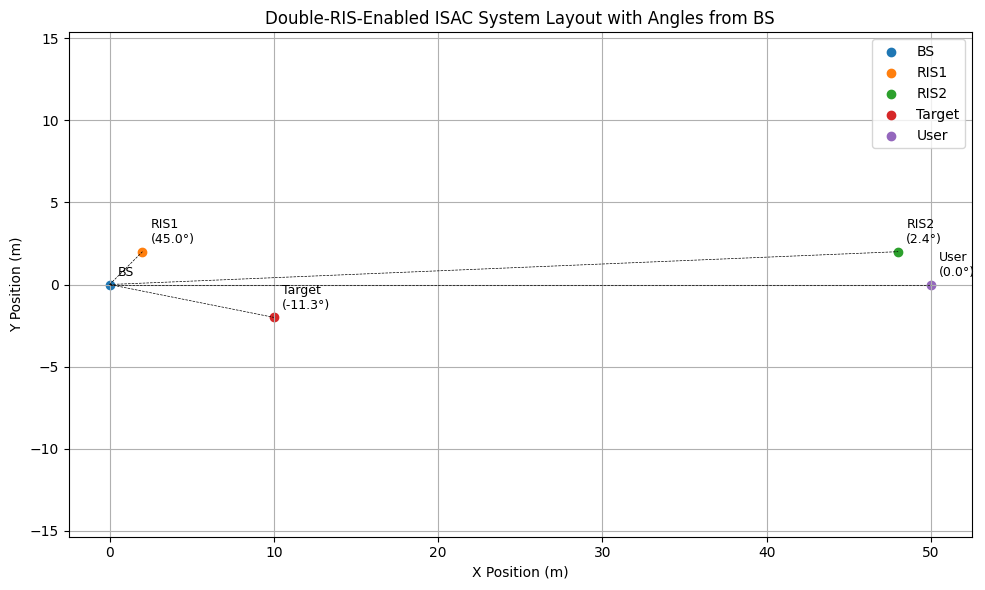

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def dbm_to_linear(dbm):
    return 10 ** (dbm / 10)

# Posisi entitas berdasarkan paper (dalam meter)
positions = {
    "BS": (0, 0),
    "RIS1": (2, 2),
    "RIS2": (48, 2),
    "Target": (10, -2),
    "User": (50, 0)
}
path_loss_exp={
    "H_1": 2.2,
    "h_bk": 2.5,
    "h_1k": 2.5,
    "h_2k": 2.2,
    "H_2": 2.2,
    'G':2.5
}
# mW -> dBm = 10*log(P)
# -30dBm -> 10^-3mW -> 10^-6 W  convert to linear
path_loss_ref={
    "H_1": dbm_to_linear(-30),
    "h_bk": dbm_to_linear(-30),
    "h_1k": dbm_to_linear(-30),
    "h_2k": dbm_to_linear(-30),
    "H_2": dbm_to_linear(-30),
    "G": dbm_to_linear(-30),
}
# (RX,TX)
N1 = 10
N2 = 10
M = 8
ch_size ={
  "H_1": (N1,M),
  "h_bk": (1,M),
  "h_1k": (1,N1),
  "h_2k": (1,N2),
  "H2": (N2,M),
  "G": (N2,N1)
}
rician_factor ={
  "H_1": 3,
  "h_bk": 1,
  "h_1k": 3,
  "h_2k": 3,
  "H_2": 3,
  "G": 3
}


# Fungsi hitung jarak dan sudut phi
def get_distance_and_phi(src, dst):
    dx = positions[dst][0] - positions[src][0]
    dy = positions[dst][1] - positions[src][1]
    dist = np.sqrt(dx**2 + dy**2)
    phi_rad = np.arctan2(dy, dx)
    phi_deg = np.degrees(phi_rad)
    return dist, phi_rad, phi_deg
def distance_channel_meter_func(src, dst):
    dx = dst[0] - src[0]
    dy = dst[1] - src[1]
    dist = np.sqrt(dx**2 + dy**2)
    return dist
def angle_phi_rad(src, dst):
    dx = dst[0] - src[0]
    dy = dst[1] - src[1]
    phi_rad = np.arctan2(dy, dx)
    return phi_rad
def angle_phi_deg(src, dst):
    phi_deg = np.degrees(angle_phi_rad(src, dst))
    return phi_deg

distance_channel_meter ={
  "H_1": distance_channel_meter_func(positions['BS'],positions['RIS1']),
  "h_bk": distance_channel_meter_func(positions['BS'],positions['Target']),
  "h_1k": distance_channel_meter_func(positions['RIS1'],positions['Target']),
  "h_2k": distance_channel_meter_func(positions['RIS2'],positions['Target']),
  "H_2": distance_channel_meter_func(positions['BS'],positions['RIS2']),
  "G": distance_channel_meter_func(positions['RIS1'],positions['RIS2'])
}
angle_channel_rad ={
  "H_1": angle_phi_rad(positions['BS'],positions['RIS1']),
  "h_bk": angle_phi_rad(positions['BS'],positions['Target']),
  "h_1k": angle_phi_rad(positions['RIS1'],positions['Target']),
  "h_2k": angle_phi_rad(positions['RIS2'],positions['Target']),
  "H_2": angle_phi_rad(positions['BS'],positions['RIS2']),
  "G": angle_phi_rad(positions['RIS1'],positions['RIS2'])
}

# Daftar channel dan pasangan node
channel_list = [
    ("BS", "RIS1", "BS → RIS1 (H1)"),
    ("BS", "RIS2", "BS → RIS2 (H2)"),
    ("BS", "Target", "BS → Target"),
    ("BS", "User", "BS → User"),
    ("RIS1", "RIS2", "RIS1 → RIS2 (G)"),
    ("RIS1", "Target", "RIS1 → Target"),
    ("RIS1", "User", "RIS1 → User"),
    ("RIS2", "User", "RIS2 → User"),
    ("RIS2", "Target", "RIS2 → Target"),
]

# Cetak header tabel
print("Channel".ljust(25), "Distance (m)".ljust(15), "φ (rad)".ljust(12), "φ (°)")
print("-" * 65)

# Cetak tiap baris data
for src, dst, label in channel_list:
    d, phi_r, phi_d = get_distance_and_phi(src, dst)
    print(label.ljust(25),
          f"{d:>10.2f}".ljust(15),
          f"{phi_r:+.4f}".ljust(12),
          f"{phi_d:+.2f}")

# Fungsi menghitung sudut (dalam derajat) terhadap BS
def angle_from_bs(pos_bs, pos_target):
    dx = pos_target[0] - pos_bs[0]
    dy = pos_target[1] - pos_bs[1]
    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

# Hitung sudut dari BS ke semua titik lain
angles = {label: angle_from_bs(positions["BS"], pos) for label, pos in positions.items() if label != "BS"}

# Plot
plt.figure(figsize=(10, 6))
for label, (x, y) in positions.items():
    plt.scatter(x, y, label=label)
    if label != "BS":
        angle = angles[label]
        plt.text(x + 0.5, y + 0.5, f"{label}\n({angle:.1f}°)", fontsize=9)
    else:
        plt.text(x + 0.5, y + 0.5, label, fontsize=9)

# Tambahkan garis arah dari BS ke titik lainnya
for label, (x, y) in positions.items():
    if label != "BS":
        plt.plot([positions["BS"][0], x], [positions["BS"][1], y], 'k--', linewidth=0.5)

plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Double-RIS-Enabled ISAC System Layout with Angles from BS')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()



## Function : Initial Parameters


Initialize the values of $ \{ \mathbf{w}_{c,k}, \mathbf{w}_{r,m}, \mathbf{v}_1, \mathbf{v}_2 \}$ to $
 \{ \mathbf{w}_{c,k}^0, \mathbf{w}_{r,m}^0, \mathbf{v}_1^0, \mathbf{v}_2^0 \}, $ respectively

 where

 $\mathbf{v}_1 \in \mathbb{C}^{N_1 \times 1}$ is the phase shift vector for RIS1, defined as:

$$
\mathbf{v}_1 = [\psi_1, \ldots, \psi_{N_1}]^H
$$

With the constraint:

$$
|\mathbf{v}_1[j]| = 1, \quad \forall j = 1, \ldots, N_1
$$

This means that each element of $\mathbf{v}_1$ has unit modulus (magnitude 1), i.e., it only adjusts the phase of the reflected signal without changing its amplitude.

Similarly, $\mathbf{v}_2$ is the phase shift vector for RIS2 (if applicable), also with:

$$
|\mathbf{v}_2[j]| = 1, \quad \forall j
$$



In [61]:
def initialize_parameters(K, M, N1, N2):
  # K, num of user,
  # M, num of transmit antenna
  # N1 and N2, num of elements in RIS1 and RIS2
  # bener
    """ Initialize beamforming vectors and phase shifts """
    wc = [np.random.randn(M, 1) + 1j * np.random.randn(M, 1) for _ in range(K)] # K jumlah user
    wr = [np.random.randn(M, 1) + 1j * np.random.randn(M, 1) for _ in range(M)]
    v1 = np.exp(1j * 2 * np.pi * np.random.rand(N1, 1))
    v2 = np.exp(1j * 2 * np.pi * np.random.rand(N2, 1))
    return wc, wr, v1, v2

## Function Rician Channel



In [62]:
def rician_channel(ch_size, rician_factor, dist, path_loss_ref, dist_ref, path_loss_exp, freq, phi):
    """
    Generate a Rician MIMO channel matrix.

    Parameters:
    - ch_size: tuple (N_ar, N_at), number of RX and TX antennas
    - rician_factor: K-factor (linear scale)
    - dist: distance between TX and RX [m]
    - path_loss_ref: reference path loss (linear)
    - dist_ref: reference distance [m]
    - path_loss_exp: path loss exponent
    - freq: frequency [Hz]
    - phi: angle of arrival [radian]

    Returns:
    - H: complex-valued MIMO channel matrix
    """

    # Validate inputs
    if not (isinstance(ch_size, (tuple, list)) and len(ch_size) == 2):
        raise ValueError("ch_size must be a tuple/list of length 2")

    N_ar, N_at = ch_size
    # if any(x <= 0 for x in [rician_factor, dist, path_loss_ref, dist_ref, path_loss_exp, freq]):
    #     raise ValueError("All physical parameters must be positive scalars")

    # Path loss
    L_d = path_loss_ref * (dist / dist_ref) ** (-path_loss_exp)

    # Wave-related constants
    c = 3e8  # speed of light [m/s]
    wavelength = c / freq
    k = 2 * np.pi / wavelength
    d_a = wavelength / 2

    # Steering vectors
    row_idx = np.arange(N_ar).reshape(-1, 1)
    col_idx = np.arange(N_at).reshape(-1, 1)
    er = (1 / np.sqrt(N_ar)) * np.exp(1j * k * d_a * row_idx * np.sin(phi))
    et = (1 / np.sqrt(N_at)) * np.exp(1j * k * d_a * col_idx * np.sin(phi))

    # NLOS component
    H_NLOS = np.random.randn(N_ar, N_at) + 1j * np.random.randn(N_ar, N_at)

    # Rician channel
    H = np.sqrt(L_d) * (
        np.sqrt(rician_factor / (1 + rician_factor)) * er @ et.T +
        np.sqrt(1 / (1 + rician_factor)) * H_NLOS
    )

    return H

# # TEST Example
# H = rician_channel(
#     ch_size=(4, 4),
#     rician_factor=10,
#     dist=1,
#     path_loss_ref=1,
#     dist_ref=1,
#     path_loss_exp=2,
#     freq=2.4e9,
#     phi=np.pi / 10
# )

# print("Channel matrix H:\n", H)



##  Function : Total Transmit Power

Calculate the total transmit power $P_b^\nu$:

$$
\color{green}{P_b^\nu} \triangleq \sum_{k \in \mathcal{K}} \|\mathbf{w}_{c,k}\|^2 + \sum_{m \in \mathcal{M}} \|\mathbf{w}_{r,m}\|^2
$$
based on equation (2):
$$
\color{green}{\mathbb{E}\{\mathbf{x}^H \mathbf{x}\}} = \sum_{k \in \mathcal{K}} \|\mathbf{w}_{c,k}\|^2 + \sum_{m \in \mathcal{M}} \|\mathbf{w}_{r,m}\|^2.
$$

In [63]:
def total_transmit_power(wc, wr):
    """ Calculate the total transmit power """
    # l2norm wc
    l2norm_wc = [np.linalg.norm(w) for w in wc]
    l2norm_wr = [np.linalg.norm(w) for w in wr]
    Pb_nu = sum(l2norm_wc) + sum(l2norm_wr)
    return Pb_nu

## Function : Update Beamformer $\{\mathbf{w}_{c,k}\}^{\nu+1}$ and $\{\mathbf{w}_{r,m}\}^{\nu+1}$ with given $\mathbf{v}_1^\nu$ and $\mathbf{v}_2^\nu$

\begin{aligned}
\min_{\{\mathbf{w}_{c,k}\}, \{\mathbf{w}_{r,m}\}} \quad & \sum_{k \in \mathcal{K}} \|\mathbf{w}_{c,k}\|^2 + \sum_{m \in \mathcal{M}} \|\mathbf{w}_{r,m}\|^2 \quad \text{(17)}\\
\text{s.t.}
\quad & \color{green}{
  \Upsilon_R \sigma_R^2 \leq \sum_{k \in \mathcal{K}} F_A(\mathbf{w}_{c,k}, \tilde{\mathbf{w}}_{c,k}) + \sum_{m \in \mathcal{M}} F_A(\mathbf{w}_{r,m}, \tilde{\mathbf{w}}_{r,m}) \quad \text{(15)} }\\
&
\color{green}{
(2^{\Gamma_k- 1} ) \left( \sum_{m \in \mathcal{M}} \mathbf{w}_{r,m}^H \mathbf{B} \mathbf{w}_{r,m} + \sum_{i \neq k, i \in \mathcal{K}} \mathbf{w}_{c,i}^H \mathbf{B} \mathbf{w}_{c,i} + \sigma_k^2 \right) \leq F_B(\mathbf{w}_{c,k}, \widetilde{\mathbf{w}}_{c,k}) \quad \text{(16)}}
\end{aligned}

Where equation (15) and (16) are result of first approximation of equation (12) and (13).


$
\Upsilon_R \sigma_R^2 \leq \sum_{k \in \mathcal{K}} \mathbf{w}_{c,k}^H \mathbf{A} \mathbf{w}_{c,k} + \sum_{m \in \mathcal{M}} \mathbf{w}_{r,m}^H \mathbf{A} \mathbf{w}_{r,m} \tag{12}
$

$
(2^{\Gamma_k- 1}) \left( \sum_{m \in \mathcal{M}} \mathbf{w}_{r,m}^H \mathbf{B} \mathbf{w}_{r,m} + \sum_{i \neq k, i \in \mathcal{K}} \mathbf{w}_{c,i}^H \mathbf{B} \mathbf{w}_{c,i} + \sigma_k^2 \right) \leq \mathbf{w}_{c,k}^H \mathbf{B} \mathbf{w}_{c,k} \tag{13}
$

First-order Approximation technique solved by
$
\color{green}{
z^H Q z \geq 2 \Re\left\{ \tilde{z}^H Q z \right\} - \tilde{z}^H Q \tilde{z} \triangleq F_Q(z, \tilde{z}) \tag{14}
}
$





where $
 \quad \mathbf{A} \triangleq |\alpha|^2 \mathbf{H}_R^H \mathbf{H}_R \succeq 0, \quad \mathbf{B} \triangleq \mathbf{h}_k \mathbf{h}_k^H \succeq 0.
$

$
\color{green}{\mathbf{H}_R} = \left( \mathbf{a}(\theta_b) + \mathbf{H}_1^H \operatorname{diag}(\mathbf{v}_1) \mathbf{a}(\theta_r) \right) \left( \mathbf{a}^H(\theta_b) + \mathbf{a}^H(\theta_r) \operatorname{diag}(\mathbf{v}_1) \mathbf{H}_1 \right)
\tag{based on 3}
$

$\color{green}{\mathbf{a}(\theta_r)} = \left[1, e^{j2\pi \frac{d}{\lambda} \sin(\theta_r)}, \cdots, e^{j2\pi \frac{(M-1)d}{\lambda} \sin(\theta_r)} \right]^T$ and $\color{green}{\mathbf{a}(\theta_b)} = \left[1, e^{j2\pi \frac{d}{\lambda} \sin(\theta_b)}, \cdots, e^{j2\pi \frac{(M-1)d}{\lambda} \sin(\theta_b)} \right]^T$ is channel steering factor betweeen BS and the sensing target. $\{\theta_b,\theta_r\}$ stands for the angles of the target relative to the BS and RIS, and respectivelt, and $\Delta$ is the interval between 2 adjecent antennas at the BS.




### Function $H_R$ and $h_k$


In [64]:
def steering_vector(theta, M, d=0.5, wavelength=1):
    """ Generate steering vector a(theta) for ULA """
    k = 2 * np.pi / wavelength
    m = np.arange(M)
    return np.exp(1j * k * d * m * np.sin(theta))

def compute_H_R(theta_b, theta_r, H1, v1, M, N1, d=0.5, freq=3*(10**9)):
    """
    Compute the radar channel matrix H_R based on the double-RIS-enabled ISAC system.

    Parameters:
        theta_b: angle from BS to target (in radians)
        theta_r: angle from RIS1 to target (in radians)
        H1: channel matrix from BS to RIS1 (N1 x M)
        v1: reflection coefficients of RIS1 (N1 x 1), unit modulus
        M: number of antennas at BS
        N1: number of elements at RIS1
        d: antenna spacing (default 0.5λ)
        wavelength: signal wavelength (default 1)

    Returns:
        H_R: effective radar channel matrix (M x M)
    """
    c = 3e8  # speed of light [m/s]
    wavelength = c / freq

    # Generate steering vectors
    a_theta_b = steering_vector(theta_b, M, d, wavelength).reshape((M, 1))  # (M x 1)
    a_theta_r = steering_vector(theta_r, N1, d, wavelength).reshape((N1, 1))  # (N1 x 1)

    # Make diagonal matrix from RIS1 phase vector
    V1 = np.diag(v1.flatten())  # (N1 x N1)

    # First term
    term1 = a_theta_b + H1.conj().T @ V1 @ a_theta_r  # (M x 1)

    # Second term (Hermitian transpose)
    term2 = a_theta_b.conj().T + a_theta_r.conj().T @ V1.conj().T @ H1  # (1 x M)

    # Final radar channel
    H_R = term1 @ term2  # (M x M)
    return H_R
def compute_hk(h_bk, h1k, h2k, H1, H2, G, v1, v2):
    """
    Compute cascaded equivalent channel h_k from BS to user k.

    Parameters:
    - h_bk: (M x 1) channel from BS to user k
    - h1k: (N1 x 1) channel from RIS1 to user k
    - h2k: (N2 x 1) channel from RIS2 to user k
    - H1: (N1 x M) channel from BS to RIS1
    - H2: (N2 x M) channel from BS to RIS2
    - G: (N2 x N1) channel from RIS1 to RIS2
    - v1: (N1 x 1) RIS1 phase shift vector (unit modulus)
    - v2: (N2 x 1) RIS2 phase shift vector (unit modulus)

    Returns:
    - h_k: (M x 1) equivalent total channel
    """
    V1 = np.diag(v1.flatten())
    V2 = np.diag(v2.flatten())

    # Direct + Single Reflection via RIS1 and RIS2 + Double Reflection
    term_direct     = h_bk
    term_ris1       = H1.conj().T @ V1.conj().T @ h1k
    term_ris2       = H2.conj().T @ V2.conj().T @ h2k
    term_double_ris = H1.conj().T @ V1.conj().T @ G.conj().T @ V2.conj().T @ h2k

    h_k = term_direct + term_ris1 + term_ris2 + term_double_ris
    return h_k


$
\color{Green}{\mathbf{H}_1} = \sqrt{\frac{\epsilon_1}{1 + \epsilon_1}} \mathbf{H}_1^{\mathrm{LOS}} + \sqrt{\frac{1}{1 + \epsilon_1}} \mathbf{H}_1^{\mathrm{NLOS}} \tag{4}
$

$H_1$ is assumed to be Rician fading channgel matrix between the BS and RIS1. $H_1^{LOS}$ is Channel MIMO Line-of-Sight. Referenced by Tse and Viswanath: Fundamentals of Wireless Communication pages 352 Eq. 7.29. $H_1^{NLOS}$ represent Reyleight fading non-LOS Component, which has i.i.d circularly symmetric complex Gaussioan entries with zero-mean and unit variance

$$
\mathbf{H^{LOS}} = a \cdot \sqrt{n_t n_r} \cdot \exp\left( -j \frac{2\pi d}{\lambda_c} \right) \cdot \mathbf{e}_r(\Omega_r) \cdot \mathbf{e}_t^*(\Omega_t)
$$
where $a = \sqrt{P_t \cdot G_t \cdot G_r} \cdot \left( \frac{\lambda}{4\pi d} \right)$ as Friis Free Space Transmission Equation. $n_t n_r$ is the power gain of the MIMO Channel, or simply $n_t$ is num of transmit antenna, $n_r$ is num of receive antenna. $\lambda_c$ is length of cerrier wave in meter. And $d$ is distance between BS and RIS1

Explain more on formula.

### Function of Update Beamformer

In [65]:
def update_beamformers(wc, wr, v1, v2,Upsilon_R_dB = 10,sigma_R2_dBm=-80,sigma_k2_dBm = -80,Gamma_k=2):
  Upsilon_R_dB = 10
  sigma_R2_dBm=-80
  sigma_k2_dBm = -80
  Gamma_k=2
  freq = 3e9
  Upsilon_R = 10 ** (Upsilon_R_dB / 10)  # = 10.0 \Upsilon_R -> Radar SNR Threshold
  sigma_R2  = 10 ** (sigma_R2_dBm / 10) / 1000  # = 1e-11 W \sigma_R2 -> Radar Noise Power

  Gamma_k = 2  # bps/Hz
  sinr_k_threshold = 2 ** Gamma_k - 1  # = 3.0 (linear SINR)
  sigma_k2 = 10 ** (sigma_k2_dBm / 10) / 1000  # = 1e-11 W

  # Inisialisasi variabel optimasi dan tebakan
  K = len(wc)
  M = len(wr)
  w_c_tilde = wc
  w_r_tilde = wr
  w_c = [cp.Variable((M, 1), complex=True) for _ in range(K)]
  w_r = [cp.Variable((M, 1), complex=True) for _ in range(M)]

  constraint_total = []
  # Building Radar SNR Constraint
  H_1 = rician_channel(
      ch_size=(N1, M), # ch_size: tuple (N_ar, N_at), number of RX and TX antennas
      rician_factor=rician_factor["H_1"], # rician_factor: K-factor (linear scale)
      dist=distance_channel_meter["H_1"], # dist: distance between TX and RX [m]
      path_loss_ref=path_loss_ref["H_1"], # path_loss_ref: reference path loss (linear)
      dist_ref=1, # dist_ref: reference distance [m]
      path_loss_exp=path_loss_exp["H_1"], # path_loss_exp: path loss exponent
      freq=freq, # freq: frequency [Hz]
      phi=angle_channel_rad['H_1'] / 10 # phi: angle of arrival [radian]
      )

  # bs_target_dist, bs_target_phi_rad, bs_target_phi_deg =get_distance_and_phi("BS","Target")
  # ris1_target_dist,ris1_target_phi_rad, ris1_target_phi_deg =get_distance_and_phi("RIS1","Target")
  H_R = compute_H_R(
      theta_b = angle_phi_rad(positions['BS'],positions["Target"]),  # angle from BS to target (in radians)
      theta_r = angle_phi_rad(positions['RIS1'],positions["Target"]),  # angle from RIS1 to target (in radians)
      H1=H_1,       # channel matrix from BS to RIS1 (N1 x M)
      v1=v1,       # reflection coefficients of RIS1 (N1 x 1), unit modulus
      M=M,        # number of antennas at BS
      N1=N1,       # number of elements at RIS1
      d=0.5,        # antenna spacing (default 0.5λ)
      freq=2.5e-9      # signal wavelength (default 1)
      )

  # Buat matriks A = |alpha|^2 * H_R^H * H_R
  alpha = 1 + 0j # Based on Paper |\alpha|^2 = 1
  A = (np.abs(alpha) ** 2) * (H_R.conj().T @ H_R)

  #Radar SNR lower bound
  radar_snr_constraint = (
      Upsilon_R * sigma_R2 <= sum(
          # F_Q(A, w_c[k], w_c_tilde[k]) for k in range(K)
          2 * cp.real(w_c_tilde[k].conj().T @ A @ w_c[k]) - np.real(w_c_tilde[k].conj().T @ A @ w_c_tilde[k])for k in range(K)
      ) + sum(
          # F_Q(A, w_r[m], w_r_tilde[m]) for m in range(M)
          2 * cp.real(w_r_tilde[m].conj().T @ A @ w_r[m]) - np.real(w_r_tilde[m].conj().T @ A @ w_r_tilde[m])for m in range(M)
      )
  )

  ## Building COMM SINR Constraint
  constraints_comm_sinr = []

  # Interferensi dari radar dan user lain
  for k in range(K):
    # Parameter sesuai paper
    dist_ref = 1
    d_bk = 50       # BS → user (m)
    d_1k = 52       # RIS1 → user (m)
    d_2k = 2        # RIS2 → user (m)

    # Rician factor dan path loss exponent sesuai tabel
    h_bk = rician_channel(
        ch_size=(1, M),
        rician_factor=rician_factor['h_bk'],
        dist=distance_channel_meter["h_bk"],
        path_loss_ref = path_loss_ref['h_bk'],
        dist_ref=dist_ref,
        path_loss_exp=path_loss_exp['h_bk'],
        freq=freq,
        phi=angle_channel_rad['h_bk']
      )
    h1k  = rician_channel(
        ch_size=(1, N1),
        rician_factor=rician_factor['h_1k'],
        dist=distance_channel_meter['h_1k'],
        path_loss_ref=path_loss_ref['h_1k'],
        dist_ref = dist_ref,
        path_loss_exp=path_loss_exp["h_1k"],
        freq=freq,
        phi=angle_channel_rad['h_1k']
      )
    h2k  = rician_channel(
        ch_size=(1, N2),
        rician_factor=rician_factor['h_2k'],
        dist=distance_channel_meter['h_2k'],
        path_loss_ref=path_loss_ref['h_2k'],
        dist_ref=dist_ref,
        path_loss_exp=path_loss_exp['h_2k'],
        freq=freq,
        phi=angle_channel_rad['h_2k']
        )

    # Channel BS → RIS2
    H2 = rician_channel(
        ch_size=(N2, M),
        rician_factor=rician_factor['H_2'],
        dist=distance_channel_meter['H_2'],                   # jauh (paper)
        path_loss_ref=path_loss_ref['H_2'],
        dist_ref=dist_ref,
        path_loss_exp=path_loss_exp['H_2'],
        freq=freq,
        phi=angle_channel_rad['H_2']           # arbitrary
    )

    # Channel RIS1 → RIS2
    G = rician_channel(
        ch_size=(N2, N1),
        rician_factor=rician_factor['G'],
        dist=distance_channel_meter['G'],                   # RIS1 ke RIS2
        path_loss_ref=path_loss_ref['G'],
        dist_ref=dist_ref,
        path_loss_exp=path_loss_exp['G'],
        freq=freq,
        phi=angle_channel_rad['G']           # arbitrary
    )

    # Diagonalkan phase shift
    V1 = np.diag(v1.flatten())
    V2 = np.diag(v2.flatten())

    # Total channel vector (M x 1)
    hk = h_bk.T + h1k @ V1 @ H_1 + h2k @ V2 @ H2 + h2k @ V2 @ G @ V1 @ H_1
    # hk = compute_hk(h_bk, h1k, h2k, H1, H2, G, v1, v2):

    B = hk @ hk.conj().T
    # interference = sum(cp.quad_form(w_r[m], B) for m in range(M)) + \
    #               sum(cp.quad_form(w_c[i], B) for i in range(K) if i != k)
    interference = sum(cp.quad_form(w_r[m], B) for m in range(M))
    for i in range(K):
      if i != k:
        interference += cp.quad_form(w_c[i], B)

    lhs = 2**(Gamma_k - 1) * (interference + sigma_k2)
    # rhs = F_Q(B, w_c[k], w_c_tilde[k])
    rhs = 2 * cp.real(w_c_tilde[k].conj().T @ B @ w_c[k]) - np.real(w_c_tilde[k].conj().T @ B @ w_c_tilde[k])
    # SINR constraint: left-hand side ≤ right-hand side
    constraints_comm_sinr.append(lhs <= rhs)

  ## Merge All Constraint
  constraint_total.append(radar_snr_constraint)
  constraint_total += constraints_comm_sinr

  # Objective: minimize transmit power
  objective = cp.Minimize(
      sum(cp.sum_squares(cp.norm(w_c[k], 2)) for k in range(K)) +
      sum(cp.sum_squares(cp.norm(w_r[m], 2)) for m in range(M))
  )

  # Solve
  problem = cp.Problem(objective, constraint_total)
  # problem.solve(solver=cp.SCS)
  problem.solve(solver=cp.SCS)
  # # Output hasil optimasi
  # print("📡 Total transmit power:", problem.value)
  # print("\n📶 Optimal Communication Beamformers (w_c):")
  # for k in range(K):
  #     print(f"w_c[{k}] = {w_c[k].value.flatten()}")

  # print("\n🎯 Optimal Radar Beamformers (w_r):")
  # for m in range(M):
  #     print(f"w_r[{m}] = {w_r[m].value.flatten()}")
  w_c = [var.value for var in w_c]  # pastikan ini berisi array (M,1)
  w_c_array = np.stack(w_c, axis=0)
  w_r = [var.value for var in w_r]  # pastikan ini berisi array (M,1)
  w_r_array = np.stack(w_r, axis=0)

  return w_c_array, w_r_array
K = 3  # Number of users
M = 8  # Number of antennas at BS
N1, N2 = 10, 10  # Number of elements in RIS1 and RIS2
epsilon = 1e-2  # Convergence threshold 0.01
# Testing Function Operation
wc, wr, v1, v2 = initialize_parameters(K, M, N1, N2)
Pb_nu = total_transmit_power(wc, wr)
nu = 0 # nu in greek

wc = [np.random.randn(M, 1) + 1j * np.random.randn(M, 1) for _ in range(K)] # K jumlah user
wr = [np.random.randn(M, 1) + 1j * np.random.randn(M, 1) for _ in range(M)]
v1 = np.exp(1j * 2 * np.pi * np.random.rand(N1, 1))
v2 = np.exp(1j * 2 * np.pi * np.random.rand(N2, 1))
wc_new,wr_new = update_beamformers(wc, wr, v1, v2,Upsilon_R_dB = 10,sigma_R2_dBm=-80,sigma_k2_dBm = -80,Gamma_k=2)

## Separator Step 2

In [66]:

def solve_power_minimization(w_c_tilde, w_r_tilde, H_R, alpha, Upsilon_R, sigma_R2, B, Gamma_k, sigma_k2):
    """
    Menyusun dan menyelesaikan problem optimasi daya transmit minimum
    untuk ISAC dengan first-order approximation.

    Parameters:
    - w_c_tilde: list of np.ndarray, inisialisasi beamformer komunikasi
    - w_r_tilde: list of np.ndarray, inisialisasi beamformer radar
    - H_R: channel matrix radar (numpy array)
    - alpha: refleksi target (kompleks)
    - Upsilon_R: threshold radar SNR
    - sigma_R2: noise radar
    - B: channel matrix untuk komunikasi
    - Gamma_k: threshold SINR user
    - sigma_k2: noise komunikasi

    Returns:
    - problem.value: nilai daya total minimum
    - w_c_opt: list of optimal communication beamformers
    - w_r_opt: list of optimal radar beamformers
    """

    import cvxpy as cp

    K = len(w_c_tilde)
    M = len(w_r_tilde)

    # Buat variabel optimisasi
    w_c = [cp.Variable((M, 1), complex=True) for _ in range(K)]
    w_r = [cp.Variable((M, 1), complex=True) for _ in range(M)]

    # Objective function
    objective = cp.Minimize(
        sum(cp.sum_squares(cp.norm(w_c[k], 2)) for k in range(K)) +
        sum(cp.sum_squares(cp.norm(w_r[m], 2)) for m in range(M))
    )

    # Bangun constraint
    constraints = []
    constraints.append(radar_snr_constraint(w_c, w_r, w_c_tilde, w_r_tilde, H_R, alpha, Upsilon_R, sigma_R2))
    constraints += comm_sinr_constraints(w_c, w_r, w_c_tilde, B, Gamma_k, sigma_k2)

    # Solve problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Ambil hasil
    w_c_opt = [w.value for w in w_c]
    w_r_opt = [w.value for w in w_r]

    return problem.value, w_c_opt, w_r_opt

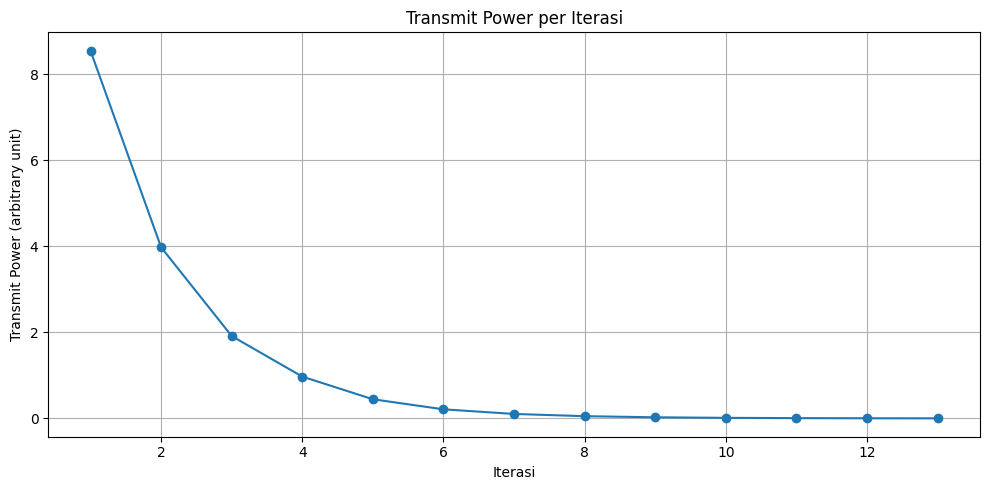

Nu 13: Transmit Power = 0.0015951420401935459


In [67]:
from IPython.display import clear_output

def transform_subproblem(wc, wr, v1, v2):
    """ Transform subproblem (18) into (32) """
    # Placeholder for transformation step
    U1 = np.random.rand(len(v1), len(v1))
    return U1

def solve_sdr(U1):
    """ Solve SDR for given matrix U1 """
    n = U1.shape[0]
    u1 = cp.Variable((n, n), complex=True)
    constraints = [u1 >> 0, cp.trace(u1) == 1]
    prob = cp.Problem(cp.Minimize(cp.real(cp.trace(U1 @ u1))), constraints)
    prob.solve()
    return u1.value

def gaussian_randomization(U1):
    """ Obtain phase shifts v1 from U1 using Gaussian randomization """
    eig_vals, eig_vecs = np.linalg.eig(U1)
    max_eig_vec = eig_vecs[:, np.argmax(eig_vals)]
    v1 = np.exp(1j * np.angle(max_eig_vec))
    return v1

K = 3  # Number of users
M = 8  # Number of antennas at BS
N1, N2 = 10, 10  # Number of elements in RIS1 and RIS2
epsilon = 1e-3  # Convergence threshold 0.01


wc, wr, v1, v2 = initialize_parameters(K, M, N1, N2)
Pb_nu = total_transmit_power(wc, wr)
nu = 0 # nu in greek


# Inisialisasi array untuk menyimpan data
nu_list = []
Pb_nu_plus1_list = []

while True:
    wc, wr = update_beamformers(wc, wr, v1, v2)
    # U1 = transform_subproblem(wc, wr, v1, v2)
    # U1_solved = solve_sdr(U1)
    # v1 = gaussian_randomization(U1_solved)
    Pb_nu_plus1 = total_transmit_power(wc, wr)

    if abs(Pb_nu_plus1 - Pb_nu) < epsilon:
        break



    Pb_nu = Pb_nu_plus1
    nu += 1

    # Visualize Data
    nu_list.append(nu)
    Pb_nu_plus1_list.append(Pb_nu_plus1)  # Contoh data eksponensial menurun dengan noise

    # Bersihkan output sebelumnya
    clear_output(wait=True)

    # Buat plot
    plt.figure(figsize=(10, 5))
    plt.plot(nu_list, Pb_nu_plus1_list, marker='o')
    plt.title('Transmit Power per Iterasi')
    plt.xlabel('Iterasi')
    plt.ylabel('Transmit Power (arbitrary unit)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Nu {nu}: Transmit Power = {Pb_nu_plus1}")

## Generate Figure Transmit Power vs N

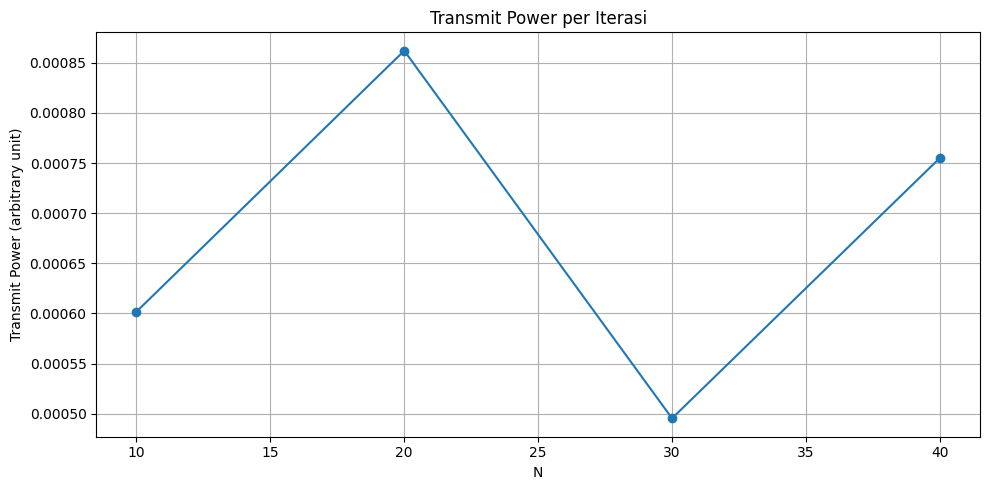

In [68]:
from IPython.display import clear_output
import time
N_list = [10,20,30,40]
convergence_power_list=[]

convergence_power_temp_count = 10

for N_dat in N_list:
  K = 3  # Number of users
  M = 8  # Number of antennas at BS
  N1, N2 = N_dat, N_dat  # Number of elements in RIS1 and RIS2
  epsilon = 1e-3  # Convergence threshold 0.01


  wc, wr, v1, v2 = initialize_parameters(K, M, N1, N2)
  Pb_nu = total_transmit_power(wc, wr)
  nu = 0 # nu in greek


  # Inisialisasi array untuk menyimpan data
  nu_list = []
  Pb_nu_plus1_list = []
  while True:
      wc, wr = update_beamformers(wc, wr, v1, v2)
      # U1 = transform_subproblem(wc, wr, v1, v2)
      # U1_solved = solve_sdr(U1)
      # v1 = gaussian_randomization(U1_solved)
      Pb_nu_plus1 = total_transmit_power(wc, wr)

      if abs(Pb_nu_plus1 - Pb_nu) < epsilon:
        convergence_power_list.append(Pb_nu_plus1)
        break



      Pb_nu = Pb_nu_plus1
      nu += 1

      # Visualize Data
      nu_list.append(nu)
      Pb_nu_plus1_list.append(Pb_nu_plus1)  # Contoh data eksponensial menurun dengan noise

      # Bersihkan output sebelumnya
      clear_output(wait=True)

      # Buat plot
      plt.figure(figsize=(10, 5))
      plt.plot(nu_list, Pb_nu_plus1_list, marker='o')
      plt.title('Transmit Power per Iterasi')
      plt.xlabel('Iterasi')
      plt.ylabel('Transmit Power (arbitrary unit)')
      plt.grid(True)
      plt.tight_layout()
      plt.show()

      print(f"Nu {nu}: Transmit Power = {Pb_nu_plus1}")

# Bersihkan output sebelumnya
clear_output(wait=True)
# Buat plot
plt.figure(figsize=(10, 5))
plt.plot(N_list, convergence_power_list, marker='o')
plt.title('Transmit Power per Iterasi')
plt.xlabel('N')
plt.ylabel('Transmit Power (arbitrary unit)')
plt.grid(True)
plt.tight_layout()
plt.show()

With Loop Convergence Power

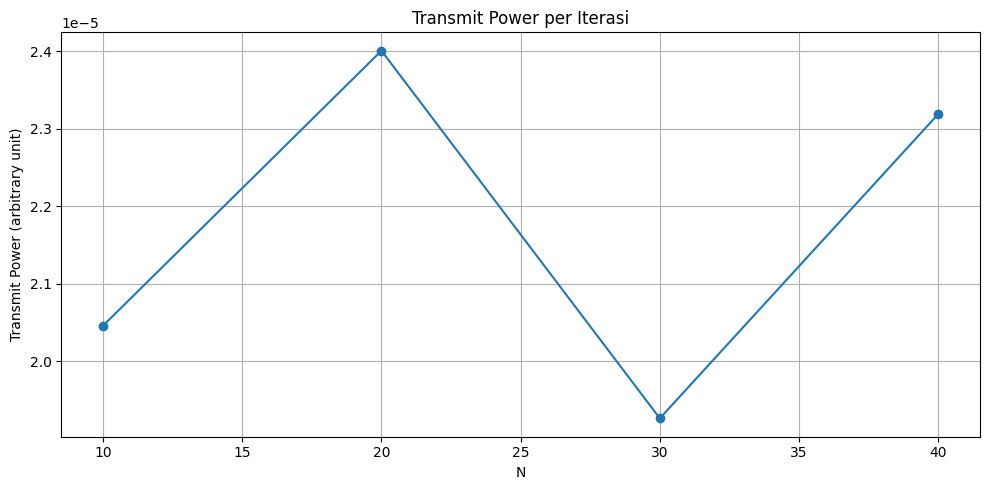

In [69]:
from IPython.display import clear_output
N_list = [10,20,30,40]
convergence_power_list=[]

convergence_power_temp_count = 50

for N_dat in N_list:
  K = 3  # Number of users
  M = 8  # Number of antennas at BS
  N1, N2 = N_dat, N_dat  # Number of elements in RIS1 and RIS2
  epsilon = 1e-3  # Convergence threshold 0.01


  wc, wr, v1, v2 = initialize_parameters(K, M, N1, N2)
  Pb_nu = total_transmit_power(wc, wr)
  nu = 0 # nu in greek


  # Inisialisasi array untuk menyimpan data
  nu_list = []
  Pb_nu_plus1_list = []

  convergence_power_temp_list = []

  for convergence_power_temp_index in range(convergence_power_temp_count):
    while True:
        wc, wr = update_beamformers(wc, wr, v1, v2)
        # U1 = transform_subproblem(wc, wr, v1, v2)
        # U1_solved = solve_sdr(U1)
        # v1 = gaussian_randomization(U1_solved)
        Pb_nu_plus1 = total_transmit_power(wc, wr)

        if abs(Pb_nu_plus1 - Pb_nu) < epsilon:
          print(f"Index Temp {convergence_power_temp_index}: Transmit Power = {Pb_nu_plus1}")
          convergence_power_temp_list.append(Pb_nu_plus1)
          break



        Pb_nu = Pb_nu_plus1
        nu += 1

        # # Visualize Data
        # nu_list.append(nu)
        # Pb_nu_plus1_list.append(Pb_nu_plus1)  # Contoh data eksponensial menurun dengan noise

        # # Bersihkan output sebelumnya
        # clear_output(wait=True)

        # # Buat plot
        # plt.figure(figsize=(10, 5))
        # plt.plot(nu_list, Pb_nu_plus1_list, marker='o')
        # plt.title('Transmit Power per Iterasi')
        # plt.xlabel('Iterasi')
        # plt.ylabel('Transmit Power (arbitrary unit)')
        # plt.grid(True)
        # plt.tight_layout()
        # plt.show()
        # time.sleep(0.2)
        # print(f"Nu {nu}: Transmit Power = {Pb_nu_plus1}")
  convergence_power_list.append(np.mean(convergence_power_temp_list))

# Bersihkan output sebelumnya
clear_output(wait=True)
# Buat plot
plt.figure(figsize=(10, 5))
plt.plot(N_list, convergence_power_list, marker='o')
plt.title('Transmit Power per Iterasi')
plt.xlabel('N')
plt.ylabel('Transmit Power (arbitrary unit)')
plt.grid(True)
plt.tight_layout()
plt.show()